Importing Libraries

In [13]:
import re
import os
import s3fs
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from general_functions import *
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import numpy as np
from scipy.interpolate import make_interp_spline
import datetime
from scipy.ndimage import gaussian_filter1d

from pyspark.sql.window import Window
from pyspark.sql.functions import *

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger('Data_Processing')
logger.info('main.py Script started')

2024-05-28 05:04:11,696 - main.py Script started


In [14]:
def generating_publisher_id_with_maximum_queries(spark, destination_path):
    try:
        """
        This function is used to transform the clean data, to get the top-5 publishers. 
        Parameters:
        destination_path: This is the path of clean folder where data is being saved. 
        spark: spark object
        returns: transformed pyspark-dataframe
        """
        df  = spark.read.parquet(destination_path)
        logger.info(f"data loaded successfully from path:{destination_path}")
        df = df.withColumn("file_creation_date", date_format('file_creation_date', "yyyy-MM-dd"))
        window_spec = Window.partitionBy('publisher_id').orderBy("publisher_id")
        x = df.withColumn("total_count_of_click", sum(col('total_clicks')).over(window_spec))
        rank_spec = Window.partitionBy().orderBy(desc(col("total_count_of_click")))
        x = x.withColumn("rank", dense_rank().over(rank_spec))
        x = x.filter(x.rank<=5)
        unique_publisher_id = list(set(x.select("publisher_id").rdd.flatMap(lambda x: x).collect()))
        v = df.filter(df.publisher_id.isin(unique_publisher_id))
        v = v.groupBy("publisher_id", "file_creation_date").agg(sum(col("total_clicks")))
        v = v.sort("publisher_id", "file_creation_date", ascending=True)
        v.show()
        v.printSchema()
        return v
    except Exception as e:
        logger.info(f"Error has been encountered at generating_publisher_id_with_maximum_queries {e}")

def generatring_line_graph_for_top_5_publishers(df,destination_path):
    try:
        """
        This function is used to generate the line_graph and save it graph folder.
        Parameters:
        destination_path[String]: Path of graph folder to save the output line-graph.
        df[Pyspark-dataframe]: Dataframe.
        returns: None
        """
        pyplt.rcParams["figure.figsize"] = (50,15)
        plt.rcParams["figure.autolayout"] = True
        plt.set_loglevel('WARNING')

        df = df.toPandas()
        x_axis = sorted(df['file_creation_date'].drop_duplicates().to_list())
        print(x_axis)
        # fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
        color_schema = ['r','y','g','c','k']
        # unique_publisher_id = sorted(list(set(df.select("publisher_id").rdd.flatMap(lambda x: x).collect())))
        
        unique_publisher_id = sorted(df['publisher_id'].drop_duplicates().to_list())
        for i in range(len(unique_publisher_id)):
            print(unique_publisher_id[i])

            x_axis = np.array(sorted(df[df['publisher_id'] == unique_publisher_id[i]]['file_creation_date'].drop_duplicates().to_list()))

            y_axis = np.array(df[df['publisher_id'] == unique_publisher_id[i]]['sum(total_clicks)'].to_list())//1000

            y_smooth = gaussian_filter1d(y_axis, sigma=1)

            # Plot smooth curve
            plt.plot(x_axis, y_smooth,  f'x-{color_schema[i]}',label=unique_publisher_id[i], linewidth=4)


        plt.xlabel('Date', size = 50, labelpad=38)
        plt.ylabel('Clicks (x 1000)', size = 50, labelpad= 38)
        plt.title('QPS', size = 50, pad = 6)
        plt.xticks(fontsize=42,rotation=45,ha='right')
        plt.yticks(fontsize=42)
        specific_y_ticks = np.arange(0, 1200, 100)

        plt.gca().set_yticks(specific_y_ticks)
        plt.grid(visible = True,axis='y', which='both',color='k', linestyle='-', linewidth=0.6, in_layout=True)
        plt.grid(visible = True,axis='x', which='both',color='k', linestyle='-', linewidth=0.6, in_layout=True)
        plt.legend(prop={'size':50})
        os.makedirs("graph",exist_ok=True)
        plt.savefig(f'{destination_path}/graph/line_graph.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        logger.info(f"Error has been encountered at generatring_line_graph_for_top_5_publishers {e}")

def apply_transformations(spark,destination_path):
    try:
        """
        This function is used to transform raw data received in Landing folder and save it in clean folder as parquet format, with partitionBy date.
        Parameters:
        destination_path: This is the path of clean folder where data is being saved. 
        spark: spark object
        returns: transformed pyspark-dataframe
        """
        print(destination_path)
        folder_path = []
        # actual_path = destination_path.replace("\\", "/")+'/Landing/click_log/2024/05/'
        actual_path = destination_path
        for outside in os.listdir(actual_path):
            for inside in os.listdir(f'{actual_path}/{outside}'):
                folder_path.append(f'{outside}/{inside}')


        for path in folder_path:
            logger.info(f"currently working on folder:{path}")
            df = spark.read.option("inferSchema", True).option("mode", "PERMISSIVE").json(f"{actual_path}{path}/")
            df = df.select('*', "ip_geo.*", "query.*").drop("query", "ip_geo")
            df = df.toDF(*get_unique_column_names(df.columns))

            df = df.drop(*get_duplicate_column_names(df))

            df = df.withColumn("real_filepath", input_file_name())

            df = df.withColumn("actual_file" , split(df.real_filepath, '/',limit=-1))
            df = df.withColumn("count_file", size(df.actual_file))
            df = df.withColumn("actual_file" , df.actual_file[col("count_file")-1]).drop("count_file")
            df = df.withColumn("file_creation_date", get_file_generation_date_udf(col("actual_file")))
            df = df.withColumn("file_creation_date", date_format(to_timestamp("file_creation_date", "yyyy-MM-dd HH-mm"), "yyyy-MM-dd HH:mm"))
            publisher_id  = get_publisher_id_column_name(df)
            df = df.na.fill("null")
            # print("this is the column structure", df.columns)
            df = df.withColumnRenamed(publisher_id, "publisher_id")
            df = df.select("publisher_id", "file_creation_date", "actual_file")
            df = df.withColumn("publisher_id", when(length(col("publisher_id")) > 6, regexp_extract(col("publisher_id"), "^(va-\d{3})|^(VA-\d{3})",0)).otherwise(col("publisher_id")))
            
            
            df = df.groupBy("publisher_id", "file_creation_date", "actual_file").agg(count("publisher_id").alias("total_clicks"))
            # # print("this is the window function count", df.count())
            df = df.withColumn("date", split(col("file_creation_date"), " ").getItem(0))
            df = df.withColumn("date", to_timestamp("date", "yyyy-MM-dd"))
            df = df.withColumn("path", lit(path))
            df.printSchema()

            df.write.partitionBy("date").mode("append").format("parquet").save(str(os.getcwd()).replace("\\", "/")+f'/clean1')
            logger.info(f"successfully saved data of {path} with partiton column date")
        return str(os.getcwd()).replace("\\", "/")+f'/clean1'
    except Exception as e:
        logger.info(f"Error has been encountered at apply_transformations {e}")


2024-05-28 05:04:11,969 - ingestion of data started from s3-path datasci-assignment/click_log/2024/05/
2024-05-28 05:04:11,971 - ingestion of data Completed successfully at location c:/Users/Admin/Downloads/backup/Landing1/
2024-05-28 05:04:11,977 - SparkSession Created Successfully
2024-05-28 05:04:11,978 - apply_transformations function started successfully reading data from location : c:/Users/Admin/Downloads/backup/Landing1/
2024-05-28 05:04:11,979 - currently working on folder:10/00


c:/Users/Admin/Downloads/backup/Landing1/
root
 |-- publisher_id: string (nullable = false)
 |-- file_creation_date: string (nullable = false)
 |-- actual_file: string (nullable = false)
 |-- total_clicks: long (nullable = false)
 |-- date: timestamp (nullable = true)
 |-- path: string (nullable = false)



2024-05-28 05:04:22,515 - successfully saved data of 10/00 with partiton column date
2024-05-28 05:04:22,516 - apply_transformations function completed saved parquet at location: c:/Users/Admin/Downloads/backup/clean1
2024-05-28 05:04:22,690 - data loaded successfully from path:c:/Users/Admin/Downloads/backup/clean1


+------------+------------------+-----------------+
|publisher_id|file_creation_date|sum(total_clicks)|
+------------+------------------+-----------------+
|      VA-010|        2024-05-10|           422010|
|      VA-010|        2024-05-11|           217302|
|      VA-010|        2024-05-12|           204954|
|      VA-010|        2024-05-13|           189722|
|      VA-010|        2024-05-14|           184835|
|      VA-010|        2024-05-15|           168999|
|      VA-010|        2024-05-16|           155086|
|      VA-010|        2024-05-17|           154875|
|      VA-010|        2024-05-18|           153639|
|      VA-010|        2024-05-19|           151091|
|      VA-010|        2024-05-20|            40700|
|      VA-235|        2024-05-10|           694702|
|      VA-235|        2024-05-11|           160056|
|      VA-235|        2024-05-12|           208094|
|      VA-235|        2024-05-13|           353697|
|      VA-235|        2024-05-14|           552194|
|      VA-23

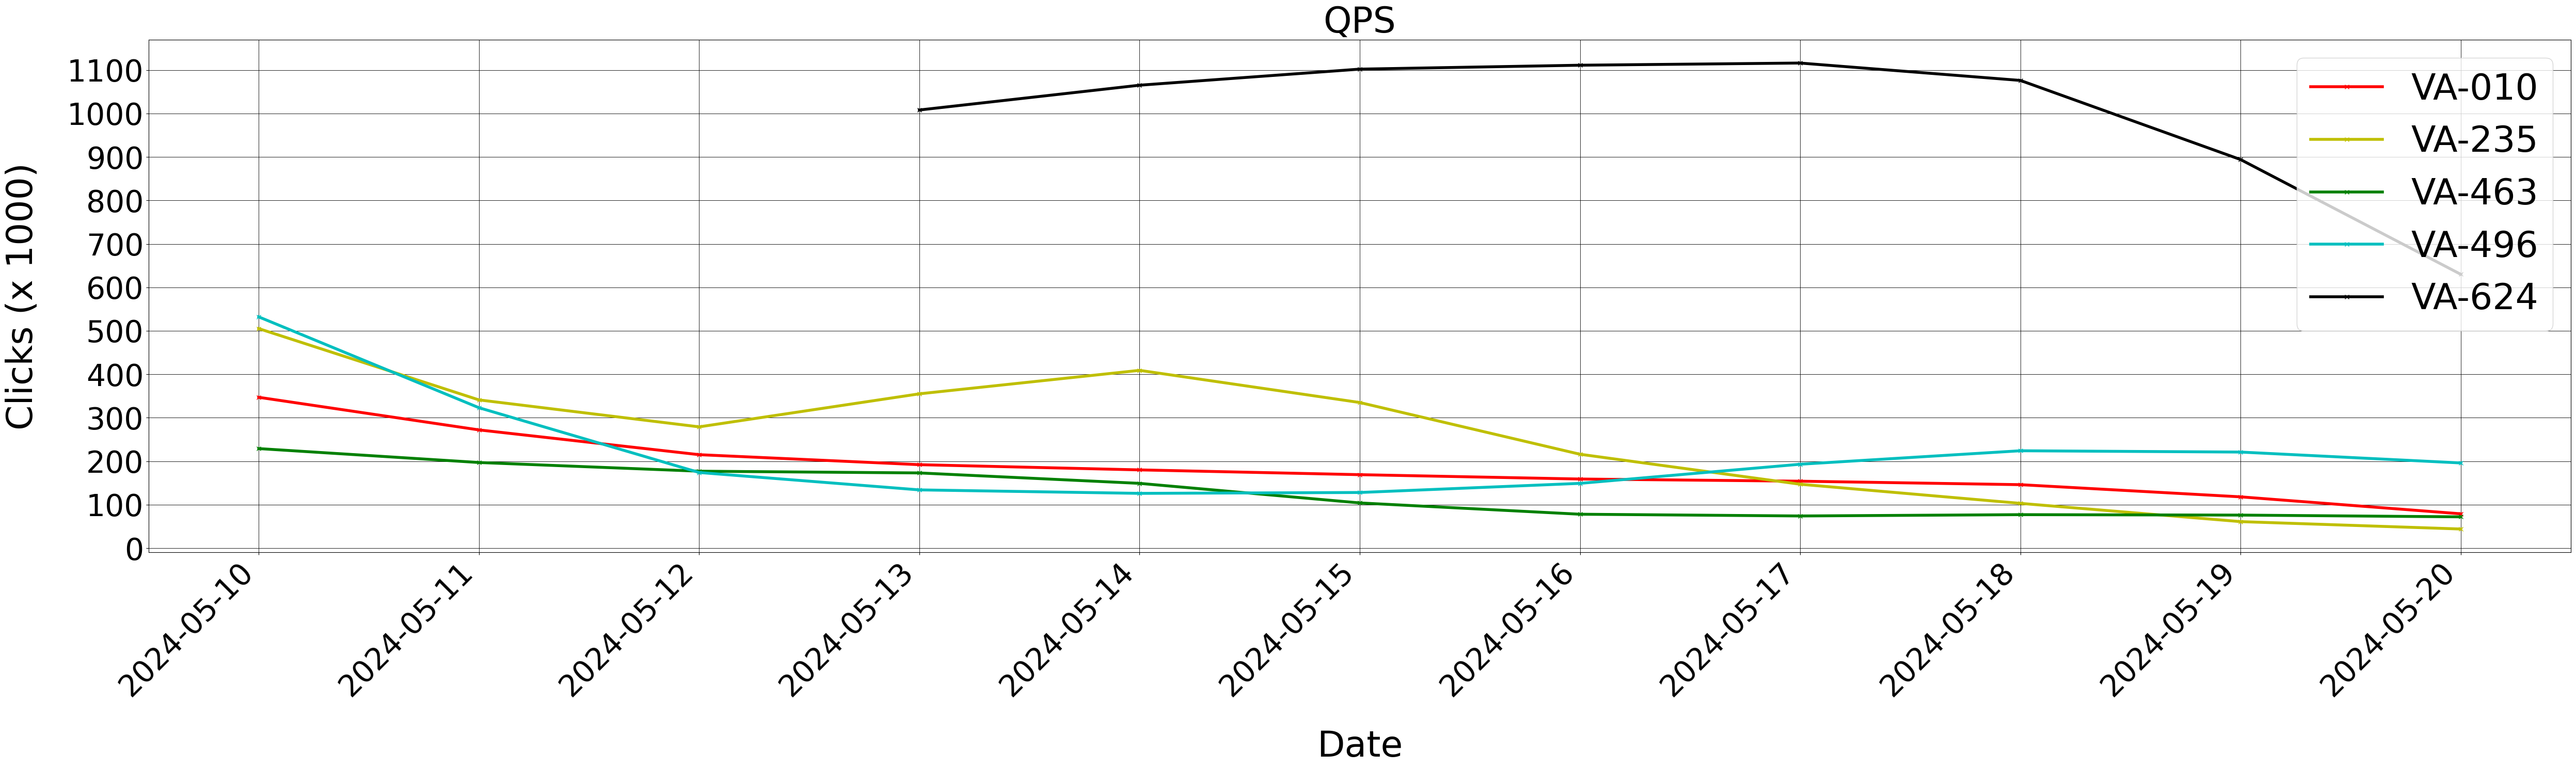

2024-05-28 05:04:34,822 - apply_transformations function completed saved parquet at location: c:/Users/Admin/Downloads/backup/clean1


In [15]:
try:
    if __name__ == "__main__":

        #public s3 path. 
        s3_path = 'datasci-assignment/click_log/2024/05/'

        #Create S3 object to read from public S3-bucket.
        s3 = s3fs.S3FileSystem(anon =  True)

        #getting currect working directory to save the files in landing location. 
        currect_working_directory = os.getcwd().replace("\\", "/")
        logger.info(f"ingestion of data started from s3-path {s3_path}")

        #Start INgesting data in Landing folder.
        destination_path  = ingest_data_from_s3(currect_working_directory, s3, s3_path)
        logger.info(f"ingestion of data Completed successfully at location {destination_path}")


        spark = SparkSession.builder.master("local[*]").appName("Batch_procecssing_pipeline_from_s3").config("spark.sql.legacy.timeParserPolicy","LEGACY").getOrCreate()
        logger.info(f"SparkSession Created Successfully")
        
        logger.info(f"apply_transformations function started successfully reading data from location : {destination_path}")
        destination_path = apply_transformations(spark,destination_path)
        logger.info(f"apply_transformations function completed saved parquet at location: {destination_path}")
        df = generating_publisher_id_with_maximum_queries(spark, destination_path)
        df.coalesce(1).write.mode("overwrite").csv("top_5_publishers_id_data")
        generatring_line_graph_for_top_5_publishers(df, os.getcwd())
        logger.info(f"apply_transformations function completed saved parquet at location: {destination_path}")
        

        
            
except Exception as e:
        logger.info(f"Error has been encountered at main {e}")